<a href="https://colab.research.google.com/github/sungjindo/pytorch/blob/main/1_5)autogradqs_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline


`파이토치(PyTorch) 기본 익히기 <intro.html>`_ ||
`빠른 시작 <quickstart_tutorial.html>`_ ||
`텐서(Tensor) <tensorqs_tutorial.html>`_ ||
`Dataset과 Dataloader <data_tutorial.html>`_ ||
`변형(Transform) <transforms_tutorial.html>`_ ||
`신경망 모델 구성하기 <buildmodel_tutorial.html>`_ ||
**Autograd** ||
`최적화(Optimization) <optimization_tutorial.html>`_ ||
`모델 저장하고 불러오기 <saveloadrun_tutorial.html>`_

``torch.autograd``\ 를 사용한 자동 미분
==========================================================================

신경망을 학습할 때 가장 자주 사용되는 알고리즘은 **역전파**\ 입니다. 이 알고리즘에서,
매개변수(모델 가중치)는 주어진 매개변수에 대한 손실 함수의 **변화도(gradient)**\ 에
따라 조정됩니다.

이러한 변화도를 계산하기 위해 PyTorch에는 ``torch.autograd``\ 라고 불리는 자동 미분 엔진이
내장되어 있습니다. 이는 모든 계산 그래프에 대한 변화도의 자동 계산을 지원합니다.

입력 ``x``, 매개변수 ``w``\ 와 ``b`` , 그리고 일부 손실 함수가 있는 가장 간단한 단일 계층
신경망을 가정하겠습니다. PyTorch에서는 다음과 같이 정의할 수 있습니다:


In [2]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

Tensor, Function과 연산그래프(Computational graph)
------------------------------------------------------------------------------------------

이 코드는 다음의 **연산 그래프** 를 정의합니다:
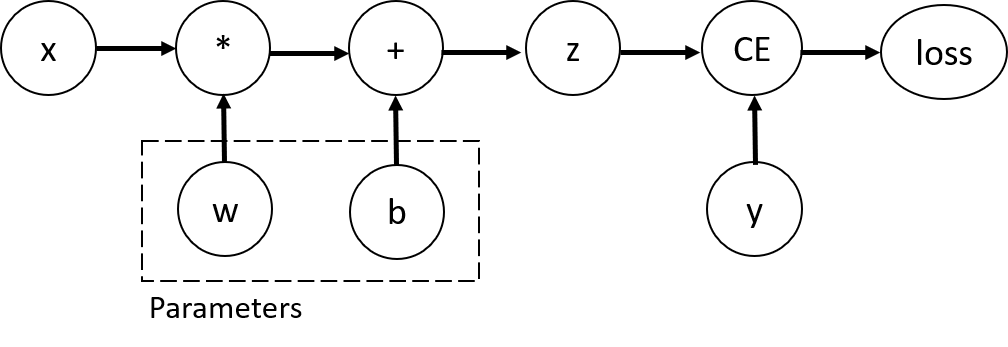

이 신경망에서, ``w``\ 와 ``b``\ 는 최적화를 해야 하는 **매개변수**\ 입니다. 따라서
이러한 변수들에 대한 손실 함수의 변화도를 계산할 수 있어야 합니다. 이를 위해서 해당 텐서에
``requires_grad`` 속성을 설정합니다.



<div class="alert alert-info"><h4>Note</h4><p>``requires_grad``\ 의 값은 텐서를 생성할 때 설정하거나, 나중에
          ``x.requires_grad_(True)`` 메소드를 사용하여 나중에 설정할 수도 있습니다.</p></div>



연산 그래프를 구성하기 위해 텐서에 적용하는 함수는 사실 ``Function`` 클래스의 객체입니다.
이 객체는 *순전파* 방향으로 함수를 계산하는 방법과, *역방향 전파* 단계에서 도함수(derivative)를
계산하는 방법을 알고 있습니다. 역방향 전파 함수에 대한 참조(reference)는 텐서의 ``grad_fn``
속성에 저장됩니다. ``Function``\ 에 대한 자세한 정보는
`이 문서 <https://pytorch.org/docs/stable/autograd.html#function>`__
에서 찾아볼 수 있습니다.




In [3]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7f119f201610>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f119f2016d0>


변화도(Gradient) 계산하기
-------------------------

신경망에서 매개변수의 가중치를 최적화하려면 매개변수에 대한 손실함수의 도함수(derivative)를
계산해야 합니다. 즉, ``x``\ 와 ``y``\ 의 일부 고정값에서 $\frac{\partial loss}{\partial w}$\ 와
$\frac{\partial loss}{\partial b}$ 가 필요합니다.
이러한 도함수를 계산하기 위해, ``loss.backward()`` 를 호출한 다음 ``w.grad``\ 와
``b.grad``\ 에서 값을 가져옵니다:




In [4]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.0838, 0.3249, 0.2127],
        [0.0838, 0.3249, 0.2127],
        [0.0838, 0.3249, 0.2127],
        [0.0838, 0.3249, 0.2127],
        [0.0838, 0.3249, 0.2127]])
tensor([0.0838, 0.3249, 0.2127])


<div class="alert alert-info"><h4>Note</h4><p>- 연산 그래프의 잎(leaf) 노드들 중 ``requires_grad`` 속성이 ``True``\ 로 설정된
    노드들의 ``grad`` 속성만 구할 수 있습니다. 그래프의 다른 모든 노드에서는 변화도가
    유효하지 않습니다.
  - 성능 상의 이유로, 주어진 그래프에서의 ``backward``\ 를 사용한 변화도 계산은 한 번만
    수행할 수 있습니다. 만약 동일한 그래프에서 여러번의 ``backward`` 호출이 필요하면,
    ``backward`` 호출 시에 ``retrain_graph=True``\ 를 전달해야 합니다.</p></div>




변화도 추적 멈추기
------------------------------------------------------------------------------------------

기본적으로, ``requires_grad=True``\ 인 모든 텐서들은 연산 기록을 추적하고 변화도 계산을
지원합니다. 그러나 모델을 학습한 뒤 입력 데이터를 단순히 적용하기만 하는 경우와 같이 *순전파*
연산만 필요한 경우에는, 이러한 추적이나 지원이 필요없을 수 있습니다.
연산 코드를 ``torch.no_grad()`` 블록으로 둘러싸서 연산 추적을 멈출 수 있습니다:




Pytorch를 사용해서 모델링을 하다보면 다음과 같은 궁금증에 도달할 수 있다.

왜 model.eval()을 선언해놓고 또 with torch.no_grad():로 감싸주는거지?

처음 접했을 땐, 전자만 사용하면 되지않나라고 막연하게 생각할 수도 있다. 그렇지만, 이 둘 사이에는 차이가 있다.

with torch.no_grad()
이와 같이 no_grad() with statement에 포함시키게 되면 Pytorch는 autograd engine을 꺼버린다. 이 말은 더 이상 자동으로 gradient를 트래킹하지 않는다는 말이 된다. 그러면 이런 의문이 들 수 있다. loss.backward()를 통해 backpropagation을 진행하지 않는다면 뭐 gradient를 게산하든지 말든지 큰 상관이 없는 것이 아닌가?

맞는 말이다. torch.no_grad()의 주된 목적은 autograd를 끔으로써 메모리 사용량을 줄이고 연산 속도를 높히기 위함이다. 사실상 어짜피 안쓸 gradient인데 inference시에 굳이 계산할 필요가 없지 않은가?

그래서 일반적으로 inference를 진행할 때는 torch.no_grad() with statement로 감싼다는 사실을 알면 된다.

model.eval()
그럼 여기서 다시 처음 질문으로 돌아와서 위의 torch.no_grad()만 쓰면 되지 않나? gradient 계산 안하고 이제 됐잖아 라고 생각할 수 있다. 맞는 말이지만, model.eval()의 역할은 약간 다르다. 현재(2019년) 시점에서는 모델링 시 training과 inference시에 다르게 동작하는 layer들이 존재한다. 예를 들면, Dropout layer는 학습시에는 동작해야하지만, inference시에는 동작하지 않는 것과 같은 예시를 들 수 있다. BatchNorm같은 경우도 마찬가지다.

사실상 model.eval()는 이런 layer들의 동작을 inference(eval) mode로 바꿔준다는 목적으로 사용된다. 따라서, 우리가 보통 원하는 모델의 동작을 위해서는 위의 두 가지를 모두 사용해야하는 것이 맞다.

출처 https://coffeedjimmy.github.io/pytorch/2019/11/05/pytorch_nograd_vs_train_eval/

In [6]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():  #굳이 할 필요가 있나? -> 연산량을 줄여주기 위함
    z = torch.matmul(x, w)+b
print(z.requires_grad) 

True
False


동일한 결과를 얻는 다른 방법은 텐서에 ``detach()`` 메소드를 사용하는 것입니다:




In [7]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


변화도 추적을 멈춰야 하는 이유들은 다음과 같습니다:
  - 신경망의 일부 매개변수를 **고정된 매개변수(frozen parameter)**\ 로 표시합니다. 이는
    `사전 학습된 신경망을 미세조정 <https://tutorials.pytorch.kr/beginner/finetuning_torchvision_models_tutorial.html>`__
    할 때 매우 일반적인 시나리오입니다.
  - 변화도를 추적하지 않는 텐서의 연산이 더 효율적이기 때문에, 순전파 단계만 수행할 때
    **연산 속도가 향상됩니다.**



연산 그래프에 대한 추가 정보
------------------------------------------------------------------------------------------

개념적으로, autograd는 데이터(텐서)의 및 실행된 모든 연산들(및 연산 결과가 새로운 텐서인 경우도 포함하여)의
기록을 `Function <https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function>`__ 객체로
구성된 방향성 비순환 그래프(DAG; Directed Acyclic Graph)에 저장(keep)합니다.
이 방향성 비순환 그래프(DAG)의 잎(leave)은 입력 텐서이고, 뿌리(root)는 결과 텐서입니다.
이 그래프를 뿌리에서부터 잎까지 추적하면 연쇄 법칙(chain rule)에 따라 변화도를 자동으로 계산할 수 있습니다.

순전파 단계에서, autograd는 다음 두 가지 작업을 동시에 수행합니다:

- 요청된 연산을 수행하여 결과 텐서를 계산하고,
- DAG에 연산의 *변화도 기능(gradient function)* 를 유지(maintain)합니다.

역전파 단계는 DAG 뿌리(root)에서 ``.backward()`` 가 호출될 때 시작됩니다. ``autograd``\ 는 이 때:

- 각 ``.grad_fn`` 으로부터 변화도를 계산하고,
- 각 텐서의 ``.grad`` 속성에 계산 결과를 쌓고(accumulate),
- 연쇄 법칙을 사용하여, 모든 잎(leaf) 텐서들까지 전파(propagate)합니다.

<div class="alert alert-info"><h4>Note</h4><p>**PyTorch에서 DAG들은 동적(dynamic)입니다.**
  주목해야 할 중요한 점은 그래프가 처음부터(from scratch) 다시 생성된다는 것입니다; 매번 ``.bachward()`` 가
  호출되고 나면, autograd는 새로운 그래프를 채우기(populate) 시작합니다. 이러한 점 덕분에 모델에서
  흐름 제어(control flow) 구문들을 사용할 수 있게 되는 것입니다; 매번 반복(iteration)할 때마다 필요하면
  모양(shape)이나 크기(size), 연산(operation)을 바꿀 수 있습니다.</p></div>



다음으로는 연산 그래프 구조에 대해 소개하겠습니다. 오늘 소개할 torch의 autograd는 실행된 모든 연산들을 DAG(Directed Acyclic Graph, 방향이 존재하는 순환되지 않는 그래프)에 저장하는 특성을 가집니다. 전형적인 node(노드)와 edge(엣지)를 가지는 graph 형태로 실행 과정이 저장된다는 뜻인데요.
여기서 DAG의 잎(leave)은 input이고, 뿌리(root)는 output 텐서라고 생각하시면 됩니다. 그리고 이 그래프를 뿌리부터 잎까지 추적하며 chain rule을 적용하면 gradient descent 과정이라고 할 수 있겠죠. 

예를 들어 $a$와 $b$를 weight(매개변수, 파라미터) 로 갖는 NN에서 loss를 $Q = 3a^3 - b^2$ 라고 가정해봅시다. 여기서 gradient descent 과정을 구현하기 위해서는 다음과 같은 매개변수에 대한 미분값을 구해야 하는 상황일 것입니다.
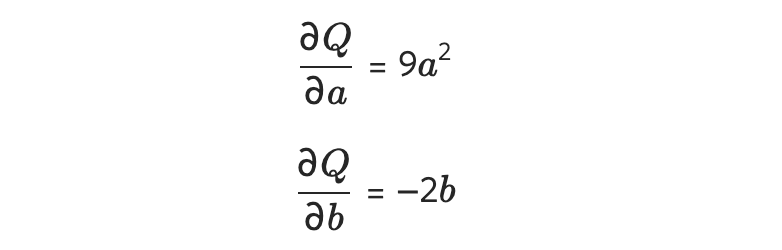

이렇게 구한 gradient로 경사하강법을 이용해 우리는 매개변수를 업데이트 하는데요, 이러한 일련의 과정을 앞서 언급한 DAG로 나타내면 다음과 같이 나타내집니다. (공식 문서의 그림을 참고해 제가 다시 그렸습니다) 

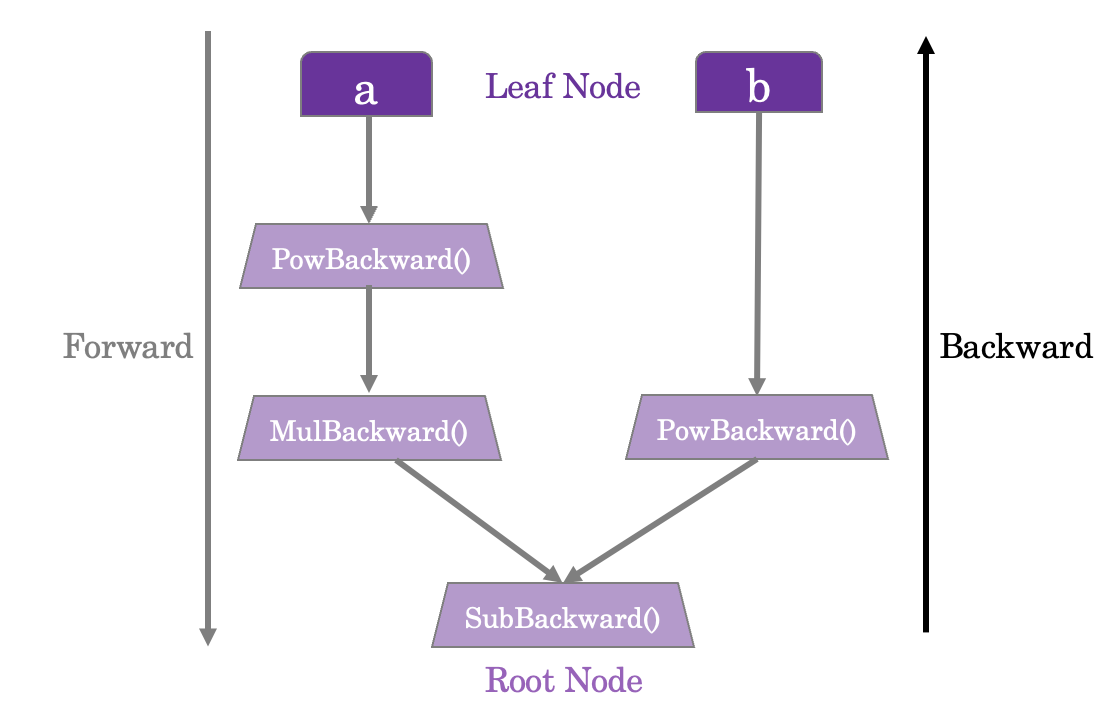

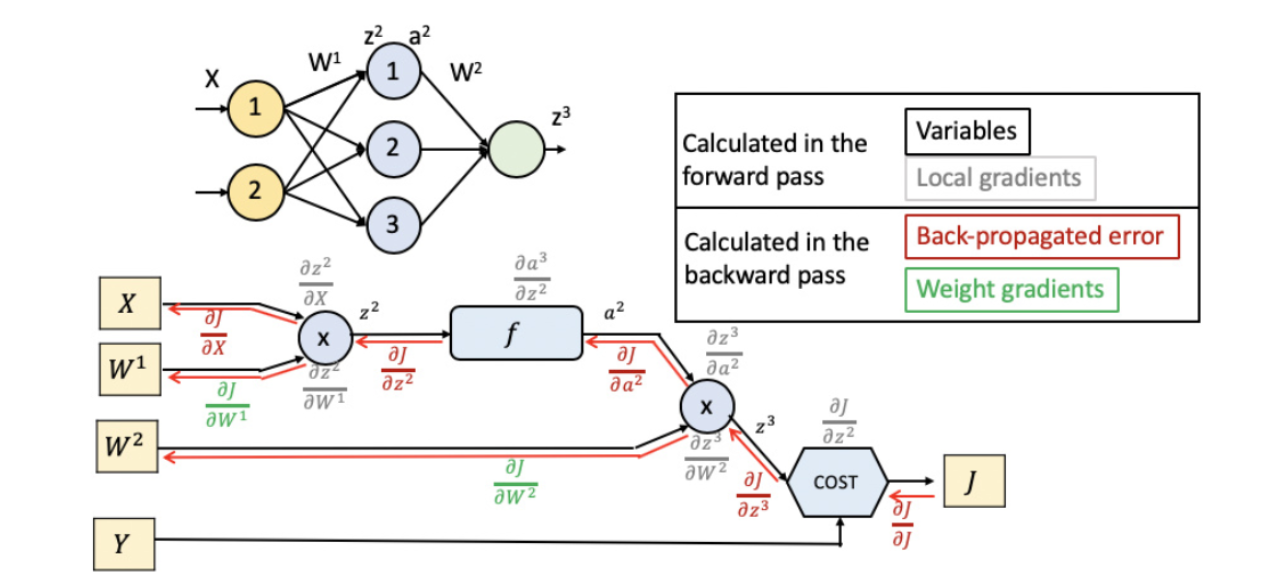

이러한 일련의 과정과 비슷하다고 보시면 될 것 같습니다.&amp;nbsp;
주의해야할 점은 이러한 DAG가 학습할 때마다 처음부터 다시 생성된다는 것입니다. autograd 함수가 호출된 때마다 매번 이러한 DAG 그래프의 모양과 크기, 연산 등이 변경됩니다.
출처:https://daeun-computer-uneasy.tistory.com/m/65

선택적으로 읽기(Optional Reading): 텐서 변화도와 야코비안 곱 (Jacobian Product)
------------------------------------------------------------------------------------------

대부분의 경우, 스칼라 손실 함수를 가지고 일부 매개변수와 관련한 변화도를 계산해야 합니다.
그러나 출력 함수가 임의의 텐서인 경우가 있습니다. 이럴 때, PyTorch는 실제 변화도가 아닌
**야코비안 곱(Jacobian product)**\ 을 계산합니다.

$\vec{x}=\langle x_1,\dots,x_n\rangle$\ 이고,
$\vec{y}=\langle y_1,\dots,y_m\rangle$\ 일 때
벡터 함수 $\vec{y}=f(\vec{x})$\ 에서 $\vec{x}$\ 에 대한
$\vec{y}$ 의 변화도는 **야코비안 행렬(Jacobian matrix)**\ 로 주어집니다:

\begin{align}J=\left(\begin{array}{ccc}
      \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
      \end{array}\right)\end{align}

야코비안 행렬 자체를 계산하는 대신, PyTorch는 주어진 입력 벡터 $v=(v_1 \dots v_m)$\ 에 대한
**야코비안 곱(Jacobian Product)**  $v^T\cdot J$\ 을 계산합니다.
이 과정은 $v$\ 를 인자로 ``backward``\ 를 호출하면 이뤄집니다. $v$\ 의 크기는
곱(product)을 계산하려고 하는 원래 텐서의 크기와 같아야 합니다.




In [8]:
inp = torch.eye(5, requires_grad=True)
out = (inp+1).pow(2)
out.backward(torch.ones_like(inp), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(inp), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(inp), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.],
        [4., 4., 4., 4., 8.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])


동일한 인자로 ``backward``\ 를 두차례 호출하면 변화도 값이 달라집니다.
이는 ``역방향`` 전파를 수행할 때, PyTorch가 **변화도를 누적(accumulate)해두기 때문**\
입니다. 즉, 계산된 변화도의 값이 연산 그래프의 모든 잎(leaf) 노드의 ``grad`` 속성에
추가됩니다. 따라서 제대로된 변화도를 계산하기 위해서는 ``grad`` 속성을 먼저 0으로 만들어야
합니다. 실제 학습 과정에서는 *옵티마이저(optimizer)*\ 가 이 과정을 도와줍니다.



<div class="alert alert-info"><h4>Note</h4><p>이전에는 매개변수 없이 ``backward()`` 함수를 호출했습니다. 이는 본질적으로
          ``backward(torch.tensor(1.0))`` 을 호출하는 것과 동일하며,
          신경망 훈련 중의 손실과 같은 스칼라-값 함수의 변화도를 계산하는 유용한 방법입니다.</p></div>




--------------




더 읽어보기
~~~~~~~~~~~~~~~~~
- `Autograd Mechanics <https://pytorch.org/docs/stable/notes/autograd.html>`_

